# Recommender Systems & Collaborative Filtering
--------
## Contents
---------

__[1. Introduction](#first-bullet)__

__[2. Preprocessing & Basic Statistics](#second-bullet)__

__[3. User-User Collaborative Filtering](#third-bullet)__

__[4. Next Steps](#fourth-bullet)__


--------
## Introduction <a class="anchor" id="first-bullet"></a>
---------

Recommender systems are one of the most important applications of data science across the consumer-facing technology industry.  They are used almost everywhere; examples are 'Amazon’s Recommended Items', Internet Radio stations, and suggested videos on Netflix.  There are two general approaches to recommender systems:

1. <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">Collaborative filtering</a>

2. <a href="https://en.wikipedia.org/wiki/Recommender_system#Content-based_filtering">Content-based filtering</a>

Collaborative filtering is a method of recommending products to customers by using their past behaviors or product ratings, as well as similar decisions by other customers to predict which items might be appealing to the original customers. Content-based filtering suggests products to customers by using the characteristics of an item they have selected in the past in order to recommend additional items with similar properties.  There are advantages and disadvantages to both of these methods.  

Collaborative filtering suffers from the cold start problem, meaning it requires a certain threshold of user input in order to make any recommendations. Content-based filtering, on the other hand, only requires one data point--for example, one item that a specific user has purchased--in order to produce suggestions. However, content-based filtering is limited in scope and in the relevance of its results, since it can only recommend products that are similar to the original product selected. Collaborative filtering can overcome this limitation by suggesting products not necessarily similar to previous products that user has selected, but that similar users have found appealing. Because of this ability to accurately recommend complex items without needing to understand the qualities of the items themselves, collaborative filtering is the more widely used method, and thus the focus of this blog post. Collaborative filtering is also much more popular for web-based recommendations where the data is sparse, i.e., where there is a limited number of reviews by each user or for a particular product.

---------
## Collaborative Filtering
---------

As mentioned previously, in collaborative filtering we do not need to know much about the products or the customers.  We just need to know need to know how many unique products and customers there as well as how the customers rated the products.  This information is stored in a user-item table, where the ratings are the entries in the table. An example of a user-item table can be seen below,

![table](images/table.jpg)


The ratings matrix is another representation of the user-item table where each user and item have been assigned an unique integer value. The general rating matrix $\textbf{R}$ is in $ R^{n_{u} \times n_{i}}$ where $n_{u}$ is the number of users and $n_{i}$ is the number of items.  Let $R_{i,j}$ entry correspoing to the $i$-th row and $j$-th column of the matrix $\textbf{R}$. $R_{i,j}$ is then the rating by user $i$ on item $j$.  The entries that have missing values in the matrix will be filled in with 0's.

In collaborative filtering we typically focus on two tasks. The first is,

**1.) Given a user and an item, what is the user’s likely preference for the item? **

This can also be viewed as filling in the missing values in the table above.  The second task is,

**2.) Recommend a list of $n$ items for a user based off of information we can obtain from the user-item table.  **

Within collaborative filtering there are two different modeling perspectives to answering the first question: 

-  **Memory based**: This approach uses customer rating data to compute the similarity between customers or items and make recommendations. This was an early approach used in many commercial systems and has the benefit of being easy to explain. However, it doesnt scale well with sparse data as we will discuss later.  


-  **Model based**: This approach to collaborative filtering scales much better with sparse data and can uncover hidden or latent features in our dataset.  One draw back to this method is that it can be hard to explain/justitfy the predictions.   

In this blog post I'll talk I'll go user-user collaborative filtering to predict how a given user will rate an item for now and look into other methods later on. Let's jump into the code...

---------
## Preprocessing & Basic Statistics <a class="anchor" id="second-bullet"></a>
---------
First let's load some of the basic libraries,

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install -r requirements.txt 

The directory '/home/ec2-user/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ec2-user/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


The data we will use comes from <a href="https:amazon.com">Amazon</a> and can be found <a href="http://jmcauley.ucsd.edu/data/amazon/">here</a>.  I chose the Amazon Instant Video 5 core file. The 5 core implies that each video/item has atleast 5 ratings and each users has rated atleast 5 videos/items.  Unzipping the file results in a json file that I was not  able to read using the Pandas <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html">read_json</a> function. So I read in the contents of the file using the function below:

In [3]:
from readFunctions import openFile
#df = openFile('reviews_Books_5.json.gz')
df = pd.read_csv('reviews.csv')
# import ijson
# filename = "reviews_Books_5.json"
# with open(filename, 'r') as f:
#     lists = list()
#     g=0
#     for i in f:
#         if g == 0:
#             for el in i:
#                 del el['helpful']
#             print(i)
#             g+=1
#             df = pd.read_json(i)
#     print(df)
        


    

We can get the basic info on the dataset, including the number of reviews and the column descriptions using the Pandas <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html">info</a> function,

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8898041 entries, 0 to 8898040
Data columns (total 10 columns):
Unnamed: 0        int64
reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall           float64
summary           object
unixReviewTime    int64
reviewTime        object
dtypes: float64(1), int64(2), object(7)
memory usage: 678.9+ MB


Мы также можем взглянуть на данные, посмотрев на первые несколько строк,

In [5]:
df.head(2)

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,0,A10000012B7CGYKOMPQ4L,000100039X,Adam,"[0, 0]",Spiritually and mentally inspiring! A book tha...,5.0,Wonderful!,1355616000,"12 16, 2012"
1,1,A2S166WSCFIFP5,000100039X,"adead_poet@hotmail.com ""adead_poet@hotmail.com""","[0, 2]",This is one my must have books. It is a master...,5.0,close to god,1071100800,"12 11, 2003"


Значение <code>asin</code> для каждого отзыва - это фактический идентификатор продукта или видео на Amazon. Если вы скопируете и вставите этот идентификатор/код в поиск на <a href="https://amazon.com"> amazon.com </a>, появится список продуктов!

Теперь давайте начнем с получения некоторой базовой статистики по рейтингам мгновенных видео Amazon в данных,

In [6]:
print("Mean rating : {}".format(df['overall'].mean()))
print("Mean rating standard deviation: {}".format(df['overall'].std()))

Mean rating : 4.2499322041784255
Mean rating standard deviation: 1.0577327813620996


Средний рейтинг по всем видео составляет 4,2 из 5. Мы можем увидеть общее распределение отзывов ниже

Text(0, 0.5, 'count of reviews')

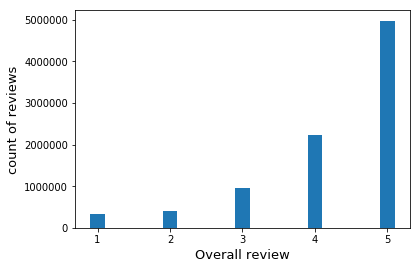

In [7]:
fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)
ax.hist(df['overall'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('Overall review', fontsize=13)
ax.set_ylabel('count of reviews', fontsize=13)
#ax.title('Distribution of reviews', fontsize=15)

Мы также можем узнать количество рецензентов, посчитав уникальные значения <code>reviewerID</code> и продукта, посчитав уникальные значения <code>asin</code>:

In [8]:
num_users = len(df['reviewerID'].unique())
num_items = len(df['asin'].unique())

print("Number of reviewers: {}".format(num_users))
print("Number of products : {}".format(num_items))
print("Number of ratings  : {}".format(len(df)))

Number of reviewers: 603668
Number of products : 367982
Number of ratings  : 8898041


Мы также можем узнать среднее количество оценок на одного рецензента, используя <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html"> groupby </a> функция с <code>reviewerID</code> и подсчет количества отзывов о товаре,


In [9]:
avg_num_reviews = df.groupby('reviewerID')['asin'].count()
print("Avg Number of ratings per reviewer {}".format(avg_num_reviews.mean()))

Avg Number of ratings per reviewer 14.739958056415116


Мы также можем получить распределение среднего рейтинга каждого рецензента,

Text(0, 0.5, 'number of reviewers')

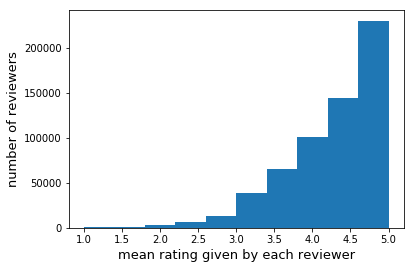

In [10]:
mean_rating_of_user = df.groupby('reviewerID').apply(lambda x: x['overall'].mean())

fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

We could keep exploring the data to get more insights, but one of the appealing aspects about collaborative filtering is that we don't actually have to know much about the products or customters' preferences in order to make recommedations. Instead, all we need to need is the user-item table or ratings matrix and this is what we will discuss next.

Now we want to make a ratings matrix out of our DataFrame to represent the user-item table.  In order to do this we have to assign each video and reviewer an unique index that will correspond to a row and a column in the matrix respectively. We do this by turning each <a href="http://pandas.pydata.org/pandas-docs/stable/categorical.html">categorical</a> data-types:

In [11]:
# turn each reviewer and product into categorical data,
df['reviewerID'] = df['reviewerID'].astype("category")
df['asin']       = df['asin'].astype("category")

We then create a matrix of all the videos/reviewer/ratings tripples for the training set.  We format the matrix such that each row is a unique item/video and each column is a unique reviewer.  The value of each matrix $R_{i,j}$ will then be the rating that a reviewer $j$ gave on video $i$:

In [12]:
reviews = csc_matrix((df['overall'].astype(float), 
                     (df['reviewerID'].cat.codes,
                      df['asin'].cat.codes)))
reviews.shape

(603668, 367982)

Поскольку большинство рецензентов / клиентов оценивают только несколько видеороликов, в этой матрице будет много записей с пропущенными значениями и по умолчанию будет иметь значение 0. Поскольку будет так мало ненулевых значений, эта матрица будет довольно разреженной, и поэтому мы должны использовать разреженную матрицу для ее хранения. Разреженная матрица хранит только ненулевые записи и уменьшает использование памяти. Однако наши данные не так велики, и плотные матрицы могут быть немного легче работать, поэтому я преобразую эту матрицу в плотную:

In [ ]:
ratings_matrix = reviews.toarray()

Мы можем видеть разреженность этой матрицы:

In [14]:
sparsity = float(len(reviews.nonzero()[0]))
sparsity /= (reviews.shape[0] * reviews.shape[1])
sparsity *= 100
print("Sparsity: {:4.2f}%".format(sparsity))

Sparsity: 0.00%


The main idea of collaborative filtering is we want to predict how each user will feel about a product, that is, to find the missing values in the matrix. One idea is to fill in the missing values with the mean rating of all users and on all products. The overall mean can be obtained by,

In [17]:
mean_rating = df['overall'].mean()

We can get then root mean square error in this prediction by computing by getting the non-zero rating values in the matrices using the above method and taking the square of the difference in these values from the <code>mean_rating</code>,

In [18]:
base_rmse = np.sqrt(pow(df['overall']-mean_rating, 2).mean())
print("RMSE = {}".format(base_rmse))

RMSE = 1.0577327219258252


This is a pretty naive approach, but it will give us a baseline to compare the other methods we use.  Our goal will be to find collaborative filtering methods that result in smaller errors than above and we will start with user-user collaborative filtering.

--------
##  User-User Collaborative Filtering <a class="anchor" id="third-bullet"></a>
--------

The basic idea of user-user collaborative filtering is to predict a customer, $u$'s rating of a product, $i$, by finding customers that are similar to $u$ and use their rating of product $i$ to estimate how customer $u$ would rate it.  The way we measure how similar customers are is through a function called the <a href="https://en.wikipedia.org/wiki/Cosine_similarity">cosine similarity</a> function.  The cosine similarity between user $u$ and user $v$ is the normalized dot product of their row vectors, ($\textbf{r}_{u}$ and $\textbf{r}_{v}$ respectively) in the rating matrix $\textbf{R}$,

$$ s(u,v) = \frac{\textbf{r}_{u} \cdot \textbf{r}_{v}}{ \Vert \textbf{r}_{u} \Vert \Vert \textbf{r}_{v} \Vert} $$

As mentioned previously, unknown ratings are considered to be 0; this causes them to effectively drop out of the numerator. To generate predictions for user $u$ on product $i$ from the cosine similarity function we then use a weighted average of some set of similar users ($N$) and thoses customers ratings of product $i$, 

$$ p_{u,i} = \bar{r}_{u} + \frac{\sum_{v \in N} s(u,v) (R_{v,i} - \bar{r}_{v})}{\sum_{v \in N} \vert s(u,v) \vert} $$

$\bar{r}_{v}$ is the mean rating of all customers on all products and  $\bar{r}_{u}$ is the mean rating of user $u$ on all products.  

In order to compute the cosine similarity function between users we import the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html">cosine_similarity</a> function from the <a href="http://scikit-learn.org/stable/">scikit-learn</a> library:

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

В итоге мы предварительно вычисляем все косинусные сходства между пользователями и формируем матрицу подобия в вызовах функций ниже. Первый пользовательский алгоритм совместной фильтрации приведен ниже. Сначала мы сравниваем сходство каждого пользователя со * всеми * другими пользователями и даем рекомендации. Обратите внимание, что мы не разбиваем наши данные на наборы для обучения и тестирования. Вместо этого мы перебираем всех пользователей и все продукты и рассматриваем каждый продукт для каждого пользователя как отсутствующее значение, а затем прогнозируем его значение. Затем мы получаем ошибку между прогнозируемым рейтингом и фактическим рейтингом.


In [20]:
def User_User_CF(reviews):
    """
    Obtains the RMSE error in the user-user collaborative 
    filtering algorithms using all the similar users.
    
    :param: reviews (numpy.ndarray) : The dense user-item matrix.
    
    :returns: RMSE of predictions
    :rvalue: float
    """
    
    # Get the user-user similarity matrix
    user_user_similarity = cosine_similarity(reviews)
    
    sqdiffs = 0
    num_preds = 0

    # to protect against divide by zero issues
    eps = 1e-6

    cnt_no_sims = 0
    # loop over the users
    for user_i, u in enumerate(reviews):
        
        # products user HAS rated
        i_rated = np.where(u>0)[0]
    
        # Get the average rating for this user
        user_avg =  i_rated.mean()
        
        # loop over all the products that each user reviewed
        # Note: these are all the non-zero entries in the row
        for i_product in i_rated:
        
            # Get all the users (indices) that
            # have also reviewed this product.
            # Note: This also includes the user of interest!
            i_has_rated = np.where(reviews[:, i_product])[0]
        
            # remove the user (indices) of interest 
            # from this column
            i_remove = np.argmin(abs(i_has_rated - user_i))
            i_others_have_rated = np.delete(i_has_rated, i_remove)
        
            # Get the ratings for product by the similar users,
            ratings = reviews[i_others_have_rated, 
                              i_product]
                    
            ratings -= user_avg
               
            # get the cosine similarity between the users
            # and other users.
            similarities = user_user_similarity[user_i,
                                                i_others_have_rated]
            
            # denominator of user_i's produdct prediction
            norm = np.sum(similarities)
            if norm==0:
                cnt_no_sims += 1
                norm = eps
            
            # prediction of user u on product i: p_{u,i}
            predicted_rating = user_avg + np.sum(np.multiply(
                                            ratings.T,
                                            similarities))/norm
            
            # actual rating by user u on product i
            actual_rating = reviews[user_i, i_product]
            
        # get the L2 difference in predicted and actual
        # rating for the user
        sqdiffs += pow(predicted_rating - actual_rating, 2.0)
        num_preds+=1
    
    # get the average of all the predictions
    rmse_cossim = np.sqrt(sqdiffs/num_preds)
    return rmse_cossim

Давайте посмотрим, насколько хорошо алгоритм работает, вычисляя среднеквадратичное отклонение прогнозируемых пользовательских рейтингов

In [21]:
user_all_rmse = User_User_CF(reviews)
print(user_all_rmse)

ValueError: Expected 2D array, got scalar array instead:
array=4.2499322041784255.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Это, безусловно, улучшение ошибки прогноза по сравнению с простым использованием средних оценок в качестве приблизительных для неизвестных оценок клиентов!

Мы могли бы улучшить время выполнения нашего алгоритма, если сократим количество клиентов, которых мы используем для выработки рекомендаций. Если клиент отличается от нашего заинтересованного клиента, то включение его в наши вычисления может не повлиять на точность прогноза, но уменьшить количество вычислений, которые мы должны сделать. Следующая функция выполняет совместную фильтрацию пользователей и пользователей так же, как и выше, но на этот раз только самые популярные $ N $ наиболее похожие клиенты прогнозируют отсутствующий рейтинг интересующего клиента:

In [20]:
def User_User_CF_TopN(reviews, N):
    """
    Obtains the RMSE error in the user-user collaborative 
    filtering algorithms using the top N most similar users.
    
    :param: reviews (numpy.ndarray) : The dense user-item matrix.
    :param: N (int) : The number of the most similar users.
    
    :returns: RMSE of predictions
    :rvalue: float
    """
    
    # Get the user-user similarity matrix
    user_user_similarity = cosine_similarity(reviews)
 
    sqdiffs = 0
    num_preds = 0

    # to protect against divide by zero issues
    eps = 1e-6

    cnt_no_sims = 0
    # loop over the users
    for user_i, u in enumerate(reviews):
        
        # products user HAS rated
        i_rated = np.where(u>0)[0]
    
        # Get the average rating for this user
        user_avg = i_rated.mean()
        
        # loop over all the products that each user reviewed
        # Note: these are all the non-zero entries in the row
        for i_product in i_rated:
        
            # Get all the users (indices) that
            # have also reviewed this product.
            # Note: This also includes the user of interest!
            i_has_rated = np.where(reviews[:, i_product]>0)[0]
        
            # remove the user (indices) of interest 
            # from this column
            i_remove = np.argmin(abs(i_has_rated - user_i))
            i_others_have_rated = np.delete(i_has_rated, i_remove)
        
            # Get the ratings for product by the similar users,
            ratings = reviews[i_others_have_rated, 
                              i_product]
                    
            ratings -= user_avg
               
            # get the cosine similarity between the users
            # and other users.
            sims = user_user_similarity[user_i,
                                        i_others_have_rated]
            
            #choose top N most similar users
            most_similar_users = sims[np.argsort(sims*-1)][:N]
            most_similar_ratings = ratings[np.argsort(sims*-1)][:N]
            
            # denominator of user_i's produdct prediction
            norm = np.sum(most_similar_users)
            if norm==0:
                cnt_no_sims += 1
                norm = eps
            
            # prediction of user u on product i: p_{u,i}
            predicted_rating = user_avg + np.sum(np.multiply(
                                            most_similar_ratings.T,
                                            most_similar_users))/norm
            
            # actual rating by user u on product i
            actual_rating = reviews[user_i, i_product]
        
        # get the L2 difference in predicted and actual
        # rating for the user
        sqdiffs += pow(predicted_rating - actual_rating, 2.0)
        num_preds+=1
    
    # get the average of all the predictions
    rmse_cossim = np.sqrt(sqdiffs/num_preds)
    return rmse_cossim

Мы можем просмотреть несколько различных вариантов выбора для $ N $ (количество наиболее похожих настроек) и посмотреть, как это число влияет на ошибку в нашем алгоритме коллаборативной фильтрации пользователь-пользователь:

In [21]:
N_users = [1,2,3,4,5,10,25,50]
top_N   = [User_User_CF_TopN(ratings_matrix, i) for i in N_users]

NameError: name 'ratings_matrix' is not defined

Теперь мы можем сравнить RMSE в различных методах рекомендации:

In [24]:
# make constant vectors
user_all = []
mean_all = []
for i in range(len(N_users)):
    user_all.append(user_all_rmse)
    mean_all.append(base_rmse)

plt.figure(figsize=(8,5))
plt.plot(N_users, top_N,    'b', label = 'User-User CF, Top N Users')
plt.plot(N_users, user_all, 'r', label = 'User-User CF, All Users')
plt.plot(N_users, mean_all, 'k', label = 'Mean Rating Of All Users')
plt.xlabel('N')
plt.ylabel('RMSE Error')
plt.legend()
plt.title('RMSE Error In Recommender Predictions')

NameError: name 'top_N' is not defined

<Figure size 576x360 with 0 Axes>

Мы видим, что после примерно 25 пользователей не наблюдается значительного улучшения прогнозирующей способности совместной фильтрации.

--------
## Next Steps... <a class="anchor" id="fourth-bullet"></a>
------

Совместная фильтрация «пользователь-пользователь», в то время как определенное улучшение по сравнению с использованием среднего рейтинга в качестве предиктора имеет некоторые серьезные ограничения. Во-первых, он плохо масштабируется, так как число пользователей растет. Это связано с тем, что поиск похожих пользователей займет больше времени по мере роста списка пользователей. Другой метод, который лучше масштабируется при увеличении пользовательской базы, - это совместная фильтрация элемент-элемент, которая невероятно похожа на совместную фильтрацию пользователь-пользователь. Еще лучшим методом является использование матричной факторизации в основанной на модели совместной фильтрации. Я скоро обновлю этот пост и подробно расскажу об использовании другого метода.
